<div class="alert alert-block alert-success">
<h1> Machine Learning - Project Cars4You</h1>
<h2> 2 - Holdout Method <h2>
<h2> Group 36 </h2>
<h3> 20225/2026 </h3>

***

## **Table of Contents**<br>

[1. **Importing libraries & Data**](#1-Importing-libraries-&-Data)<br>

[2. Train-test Split](#2-Train-test-Split)<br>

[3. Feature Engineering](#3-Feature-Engineeering)<br>
- [3.1 Encoding](#31-Encoding)<br>
- [3.2 Missing Values](#32-Missing-Values)<br>
    - [3.2.1 Dealing with Missing Values](#221-Dealing-with-Missing-Values)<br>
- [3.3 Outliers](#33-Outliers)<br>
    - [3.3.1 Outliers detection](#331-Outliers-detection)<br>
    - [3.3.2 Dealing with outliers](#332-Dealing-with-outliers)<br>
- [3.4 Scaling](#34-Scaling)<br>
    
[4 Feature Selection](#4-Feature-Selection)<br>

[5 Export](#5-Export)<br>
    

***

This notebook will consist of Feature Engineering and Selection, after Train-Test Split.

> Student Name - Artem Polikarpov
>> 20250443

> Student Name - Diogo Montenegro
>> 20250491

> Student Name - Francisco Martins
>> 20250482

> Student Name - João Cardoso
>> 20240529 


***

# 1. Import Libraries & Data

Import core libraries + sklearn utilities.

In [ ]:
# --- General scientific stack ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
sns.set()


# --- Data partition ---
from sklearn.model_selection import train_test_split


# --- Filter methods (stats) ---
# - Spearman (rank-based, robust to skew/outliers)
# - Chi-square (categorical vs target discretizations)
import scipy.stats as stats
from scipy.stats import chi2_contingency


# --- Wrappers / estimators ---
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
mean_absolute_error,
r2_score, mean_absolute_error, mean_squared_error,
median_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
)


# --- Embedded methods ---
from sklearn.linear_model import LassoCV, Lasso


# --- Scalers ---
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


# --- Housekeeping ---
import warnings
warnings.filterwarnings('ignore')


# --- Custom helpers (plotting/outlier) ---
from functions import (
histogram_boxplot, labeled_barplot, stacked_barplot,
distribution_plot_wrt_target, comparative_boxplot, comparative_barplot,
detect_outliers_iqr
)


# Optional mapping used elsewhere in the project (kept for consistency)
from vocab_prep import BRAND_MODEL_VOCAB


# --- Reproducibility ---
RSEED = 42
np.random.seed(RSEED)
pd.set_option('display.max_rows', 500)


#### Data Loading

Load **pre-cleaned** train and test sets coming from the EDA/preprocessing notebook.

In [2]:
train = pd.read_csv('train_data_EDA.csv')

test = pd.read_csv('test_data_EDA.csv')

In [3]:
train.head()

,Unnamed: 0,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,carAge,Brand_audi,...,Brand_volkswagen,transmission_automatic,transmission_manual,transmission_semi-auto,fuelType_diesel,fuelType_electric,fuelType_hybrid,fuelType_petrol,model,hasDamage
0,0,22290,28421.0,NaN,11.417268,2.0,63.0,4.0,9.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,golf,0.0
1,1,13790,4589.0,145.0,47.900000,1.5,50.0,1.0,6.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,yaris,0.0
2,2,24990,3624.0,145.0,40.900000,1.5,56.0,4.0,6.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,q2,0.0
3,3,12500,9102.0,145.0,65.700000,1.0,50.0,NaN,7.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,fiesta,0.0
4,4,22995,1000.0,145.0,42.800000,1.5,97.0,3.0,6.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2 series,0.0


# 2. Train-Test Split

**Holdout Method** — we create a fixed **validation set** to compare feature sets and models quickly.

In [4]:
# Split the DataFrame into features (X) and target variable (y)
X = train.drop('price', axis=1) 
y = train['price']  

In [ ]:
# Holdout split: 80% train / 20% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=0) 

# 3. Feature Engineering

## 3.1 Encoding

Categorical Variables = "Brand","model","transmission","fuelType", but since we have already encoded "Brand", "transmission" and "fueltype", only "model" lefts

***model*** → target-free encoding via **mean engine size per model**

In [6]:
X_train['model'].value_counts()

model
focus                    5512
c class                  4220
fiesta                   3532
golf                     2603
corsa                    1893
polo                     1775
astra                    1516
a class                  1371
3 series                 1364
kuga                     1203
unknown                  1183
yaris                    1167
mokka x                  1139
aygo                     1104
1 series                 1100
e class                  1034
a3                       1032
tiguan                    994
fabia                     855
octavia                   796
q3                        790
a4                        771
tucson                    760
a1                        747
ecosport                  669
2 series                  661
i10                       608
insignia                  584
5 series                  575
glc class                 536
4 series                  530
passat                    507
a5                        483
mokk

In [7]:
# Compute mean engineSize per model
tmp = X_train[['model', 'engineSize']].copy()
model_mean_engine = tmp.groupby('model')['engineSize'].mean()

# Compute global mean (fallback for unseen models)
global_mean_engine = X_train['engineSize'].mean()

def encoding_model(input_df):

    # Apply encoding
    input_df['model_te'] = input_df['model'].map(model_mean_engine).fillna(global_mean_engine)

    # Drop the original 'model' column to avoid redundancy
    input_df.drop(columns=['model'], inplace=True)

    return input_df


In [ ]:
# Apply the encoding learned on TRAIN to all splits
X_train = encoding_model(X_train)

X_val = encoding_model(X_val)

test_encoded = encoding_model(test)

In [9]:
X_train.sample(10)

,Unnamed: 0,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,carAge,Brand_audi,Brand_bmw,...,Brand_volkswagen,transmission_automatic,transmission_manual,transmission_semi-auto,fuelType_diesel,fuelType_electric,fuelType_hybrid,fuelType_petrol,hasDamage,model_te
18122,18122,63104.0,30.0,61.7,1.7,43.0,NaN,9.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.684778
46339,46339,29200.0,303.0,38.2,2.0,79.0,1.0,8.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.645234
40249,40249,24406.0,125.0,48.7,2.0,61.0,0.0,9.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.652950
41453,41453,6057.0,145.0,39.2,1.2,85.0,4.0,6.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.660187
21014,21014,36123.0,200.0,45.6,2.0,63.0,2.0,12.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.817788
59790,59790,33065.0,30.0,54.3,1.4,47.0,1.0,8.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.363876
36063,36063,2871.0,145.0,48.7,1.1,95.0,3.0,6.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.105911
5622,5622,7260.0,145.0,37.7,3.0,88.0,2.0,6.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3.012356
62846,62846,36440.0,0.0,78.5,1.5,73.0,0.0,8.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.105911
50038,50038,14725.0,20.0,60.1,1.0,66.0,0.0,8.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.079809


In [10]:
X_val.sample(10)

,Unnamed: 0,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,carAge,Brand_audi,Brand_bmw,...,Brand_volkswagen,transmission_automatic,transmission_manual,transmission_semi-auto,fuelType_diesel,fuelType_electric,fuelType_hybrid,fuelType_petrol,hasDamage,model_te
53668,53668,12811.0,NaN,NaN,2.0,68.0,2.0,8.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.371651
75318,75318,12390.0,200.0,42.8,2.0,73.0,2.0,10.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.651055
34710,34710,40402.0,20.0,64.2,2.1,42.0,2.0,10.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.005989
61204,61204,23139.0,150.0,42.2,1.6,66.0,1.0,8.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.444213
27274,27274,1000.0,145.0,44.8,1.5,98.0,1.0,5.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.668682
68491,68491,4387.0,NaN,NaN,1.6,NaN,1.0,NaN,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.028573
50733,50733,58173.0,145.0,65.7,1.0,89.0,NaN,8.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.424675
23212,23212,33589.0,NaN,NaN,1.5,52.0,1.0,9.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.371651
15768,15768,33215.0,0.0,NaN,1.5,88.0,1.0,8.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.886271
66362,66362,2808.0,145.0,NaN,1.0,98.0,3.0,6.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.371651


## 3.2 Missing Values

For each feature we **learn imputation rules on TRAIN**, then **apply** to VAL/TEST.

In [11]:
X_train.isna().sum()

Unnamed: 0                   0
mileage                   1437
tax                       6605
mpg                       6349
engineSize                1423
paintQuality%             1807
previousOwners            1815
carAge                    1198
Brand_audi                   0
Brand_bmw                    0
Brand_ford                   0
Brand_hyundai                0
Brand_mercedes-benz          0
Brand_opel                   0
Brand_skoda                  0
Brand_toyota                 0
Brand_unknown                0
Brand_volkswagen             0
transmission_automatic       0
transmission_manual          0
transmission_semi-auto       0
fuelType_diesel              0
fuelType_electric            0
fuelType_hybrid              0
fuelType_petrol              0
hasDamage                 1257
model_te                     0
dtype: int64

### 3.2.1 Dealing with Missing Values

We prioritize **simple, explainable** imputations tied to car characteristics (model/age) rather than global means.

previousOwners - Assume that missing values are cars with no previous owners

In [12]:
X_train['previousOwners'] = X_train['previousOwners'].fillna(0)
X_val['previousOwners'] = X_val['previousOwners'].fillna(0)
test_encoded['previousOwners'] = test_encoded['previousOwners'].fillna(0)

In [13]:
X_train['previousOwners'].unique()

array([2., 3., 1., 4., 0.])

hasDamage

In [14]:
X_train['hasDamage']=X_train['hasDamage'].fillna(0)
X_val['hasDamage'] = X_val['hasDamage'].fillna(0)
test_encoded['hasDamage'] = test_encoded['hasDamage'].fillna(0)

In [15]:
X_train['hasDamage'].unique()

array([0.])

engineSize - impute by **median per `model_te`**, fallback to **global median**.

In [16]:
X_train['engineSize'].unique()

array([1.        , 2.        , 1.2       , 2.1       , 1.6       ,
       0.7395339 , 1.4       , 1.8       , 3.        , 1.5       ,
       1.7       , 1.3       ,        nan, 1.1       , 3.82275785,
       2.2       , 4.2       , 0.16286595, 3.2       , 0.31340658,
       2.3       , 0.30707394, 4.        , 2.9       , 2.7       ,
       2.5       , 5.        , 0.15452932, 0.18642488, 5.2       ,
       2.4       , 2.06411863, 3.72371217, 2.63120047, 0.6       ,
       1.9       , 4.7       , 0.19146242, 4.4       , 2.61964142,
       2.6631132 , 2.98579344, 2.8       , 5.5       , 3.73923548,
       2.78177621, 3.5       , 6.2       , 4.5       , 0.37112737,
       5.4       , 4.1       , 4.3       , 3.6       , 2.6       ,
       6.6       ])

In [17]:
# Compute median engineSize per model 
engine_median_by_model = (
    X_train.groupby('model_te')['engineSize']
           .median()
)

global_median_engine = X_train['engineSize'].median() 

def impute_engine_size(df, per_model_median, global_median_engine):
    df['engineSize'] = (
        df['engineSize']
          .fillna(df['model_te'].map(per_model_median))
          .fillna(global_median_engine)
    )
    return df


In [18]:
# Fill NaN values in TRAIN using the per-model median
X_train  = impute_engine_size(X_train,  engine_median_by_model, global_median_engine)
# Fill NaN values in VAL using the same medians learned from TRAIN
X_val = impute_engine_size(X_val, engine_median_by_model, global_median_engine)

test_encoded = impute_engine_size(test_encoded, engine_median_by_model, global_median_engine)

In [19]:
X_train.isna().sum()

Unnamed: 0                   0
mileage                   1437
tax                       6605
mpg                       6349
engineSize                   0
paintQuality%             1807
previousOwners               0
carAge                    1198
Brand_audi                   0
Brand_bmw                    0
Brand_ford                   0
Brand_hyundai                0
Brand_mercedes-benz          0
Brand_opel                   0
Brand_skoda                  0
Brand_toyota                 0
Brand_unknown                0
Brand_volkswagen             0
transmission_automatic       0
transmission_manual          0
transmission_semi-auto       0
fuelType_diesel              0
fuelType_electric            0
fuelType_hybrid              0
fuelType_petrol              0
hasDamage                    0
model_te                     0
dtype: int64

carAge - Impute by **median per `model_te`**.

In [20]:
# Compute median carAge per model (using TRAIN only)
carAge_median_by_model = (
    X_train.groupby('model_te')['carAge']
    .median()
)

global_median_carAge = X_train['carAge'].median() 

def impute_carAge(df, per_model_median, global_median_carAge):
    
    df['carAge'] = df.apply(
    lambda row: carAge_median_by_model[row['model_te']]
    if pd.isna(row['carAge']) and row['model_te'] in carAge_median_by_model
    else row['carAge'],
    axis=1)

    return df


In [21]:
# Fill NaN values in TRAIN using the per-model median
X_train  = impute_carAge(X_train, carAge_median_by_model, global_median_carAge)
# Fill NaN values in VAL using the same medians learned from TRAIN
X_val = impute_carAge(X_val, carAge_median_by_model, global_median_carAge)

test_encoded = impute_carAge(test_encoded, carAge_median_by_model, global_median_carAge)

mileage - Impute by **median per `carAge`** (useful because mileage ~ age).

In [22]:
mileage_median_by_age = (
    X_train.groupby('carAge')['mileage']
    .median()
)

def impute_mileage(df, per_model_median):

    df['mileage'] = df.apply(
        lambda row: mileage_median_by_age[row['carAge']]
        if pd.isna(row['mileage']) and row['carAge'] in mileage_median_by_age
        else row['mileage'],
        axis=1)
    
    return df


In [23]:
X_train  = impute_mileage(X_train, mileage_median_by_age)
# Fill NaN values in VAL using the same medians learned from TRAIN
X_val = impute_mileage(X_val, mileage_median_by_age)

test_encoded = impute_mileage(test_encoded, mileage_median_by_age)

In [24]:
X_train.isna().sum()

Unnamed: 0                   0
mileage                      0
tax                       6605
mpg                       6349
engineSize                   0
paintQuality%             1807
previousOwners               0
carAge                       0
Brand_audi                   0
Brand_bmw                    0
Brand_ford                   0
Brand_hyundai                0
Brand_mercedes-benz          0
Brand_opel                   0
Brand_skoda                  0
Brand_toyota                 0
Brand_unknown                0
Brand_volkswagen             0
transmission_automatic       0
transmission_manual          0
transmission_semi-auto       0
fuelType_diesel              0
fuelType_electric            0
fuelType_hybrid              0
fuelType_petrol              0
hasDamage                    0
model_te                     0
dtype: int64

paintQuality% - Impute by **median per `carAge`** (weak signal overall, but consistent).

In [25]:
# Compute median paintQuality% per carAge (using TRAIN only)
paintQuality_median_by_age = (
    X_train.groupby('carAge')['paintQuality%']
    .median()
)

def impute_paintQuality(df, per_model_median):

    df['paintQuality%'] = df.apply(
    lambda row: paintQuality_median_by_age[row['carAge']]
    if pd.isna(row['paintQuality%']) and row['carAge'] in paintQuality_median_by_age
    else row['paintQuality%'],
    axis=1)
    
    return df

In [26]:
X_train  = impute_paintQuality(X_train, paintQuality_median_by_age)
# Fill NaN values in VAL using the same medians learned from TRAIN
X_val = impute_paintQuality(X_val, paintQuality_median_by_age)

test_encoded = impute_paintQuality(test_encoded, paintQuality_median_by_age)

In [27]:
X_train.isna().sum()

Unnamed: 0                   0
mileage                      0
tax                       6605
mpg                       6349
engineSize                   0
paintQuality%                0
previousOwners               0
carAge                       0
Brand_audi                   0
Brand_bmw                    0
Brand_ford                   0
Brand_hyundai                0
Brand_mercedes-benz          0
Brand_opel                   0
Brand_skoda                  0
Brand_toyota                 0
Brand_unknown                0
Brand_volkswagen             0
transmission_automatic       0
transmission_manual          0
transmission_semi-auto       0
fuelType_diesel              0
fuelType_electric            0
fuelType_hybrid              0
fuelType_petrol              0
hasDamage                    0
model_te                     0
dtype: int64

tax - Impute by **median per `model_te`**.

In [28]:
# Compute median tax per model (using TRAIN only)
tax_median_by_model = (
    X_train.groupby('model_te')['tax']
    .median()
)

def impute_tax(df, per_model_median):
   
   df['tax'] = df.apply(
    lambda row: tax_median_by_model[row['model_te']]
    if pd.isna(row['tax']) and row['model_te'] in tax_median_by_model
    else row['tax'],
    axis=1)
    
   return df

In [29]:
X_train  = impute_tax(X_train, tax_median_by_model)
# Fill NaN values in VAL using the same medians learned from TRAIN
X_val = impute_tax(X_val, tax_median_by_model)

test_encoded = impute_tax(test_encoded, tax_median_by_model)

In [30]:
X_train.isna().sum()

Unnamed: 0                   0
mileage                      0
tax                          0
mpg                       6349
engineSize                   0
paintQuality%                0
previousOwners               0
carAge                       0
Brand_audi                   0
Brand_bmw                    0
Brand_ford                   0
Brand_hyundai                0
Brand_mercedes-benz          0
Brand_opel                   0
Brand_skoda                  0
Brand_toyota                 0
Brand_unknown                0
Brand_volkswagen             0
transmission_automatic       0
transmission_manual          0
transmission_semi-auto       0
fuelType_diesel              0
fuelType_electric            0
fuelType_hybrid              0
fuelType_petrol              0
hasDamage                    0
model_te                     0
dtype: int64

mpg - impute by **median per `model_te`**.

In [31]:
# Compute median mpg per model (using TRAIN only)
mpg_median_by_model = (
    X_train.groupby('model_te')['mpg']
    .median()
)

def impute_mpg(df, per_model_median):
   
   df['mpg'] = df.apply(
    lambda row: mpg_median_by_model[row['model_te']]
    if pd.isna(row['mpg']) and row['model_te'] in mpg_median_by_model
    else row['mpg'],
    axis=1)
    
   return df

In [32]:
X_train  = impute_mpg(X_train, mpg_median_by_model)
# Fill NaN values in VAL using the same medians learned from TRAIN
X_val = impute_mpg(X_val, mpg_median_by_model)

test_encoded = impute_mpg(test_encoded, mpg_median_by_model)

In [33]:
X_train.isna().sum()

Unnamed: 0                0
mileage                   0
tax                       0
mpg                       0
engineSize                0
paintQuality%             0
previousOwners            0
carAge                    0
Brand_audi                0
Brand_bmw                 0
Brand_ford                0
Brand_hyundai             0
Brand_mercedes-benz       0
Brand_opel                0
Brand_skoda               0
Brand_toyota              0
Brand_unknown             0
Brand_volkswagen          0
transmission_automatic    0
transmission_manual       0
transmission_semi-auto    0
fuelType_diesel           0
fuelType_electric         0
fuelType_hybrid           0
fuelType_petrol           0
hasDamage                 0
model_te                  0
dtype: int64

## 3.3 Outliers

We flag obvious anomalies but keep realistic extremes (e.g., high mileage) to avoid biasing the used-car market tails.

### 3.3.1 Outlier detection

Outlier detection — IQR rule (very small threshold just for inspection)

Column: mileage - Number of Outliers: 2657
Column: mileage - % of Outliers: 4.37%



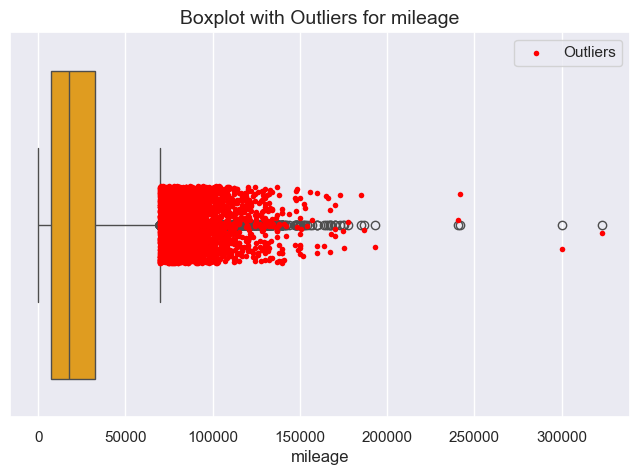

Column: tax - Number of Outliers: 16024
Column: tax - % of Outliers: 26.36%



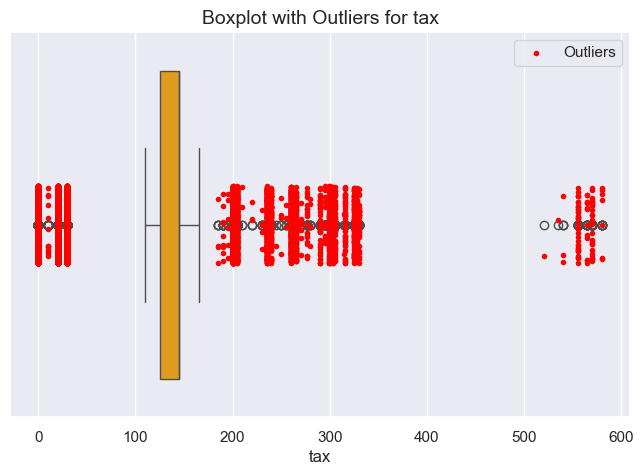

Column: mpg - Number of Outliers: 1367
Column: mpg - % of Outliers: 2.25%



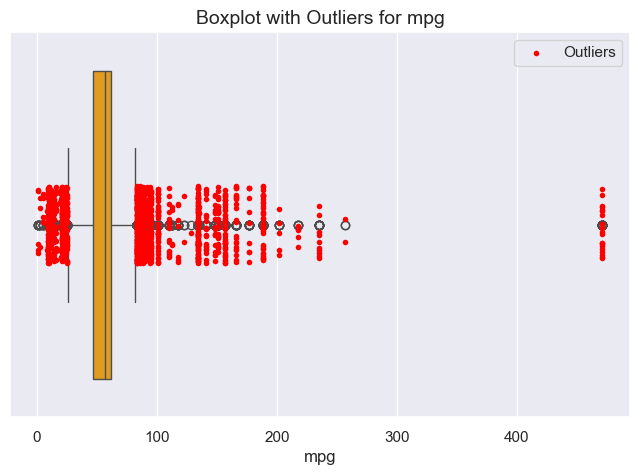

Column: engineSize - Number of Outliers: 496
Column: engineSize - % of Outliers: 0.82%



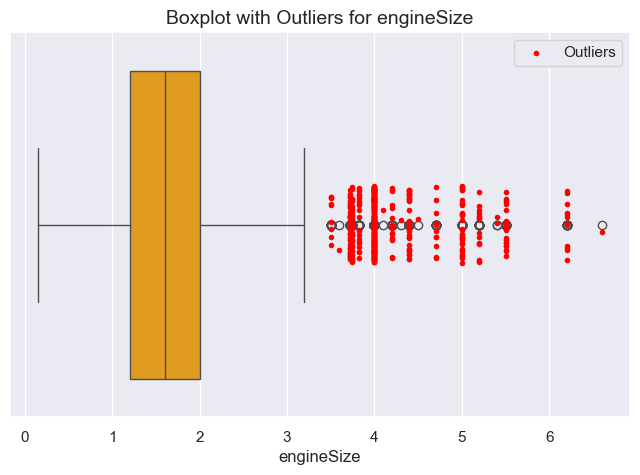

Column: paintQuality% - Number of Outliers: 0
Column: paintQuality% - % of Outliers: 0.00%



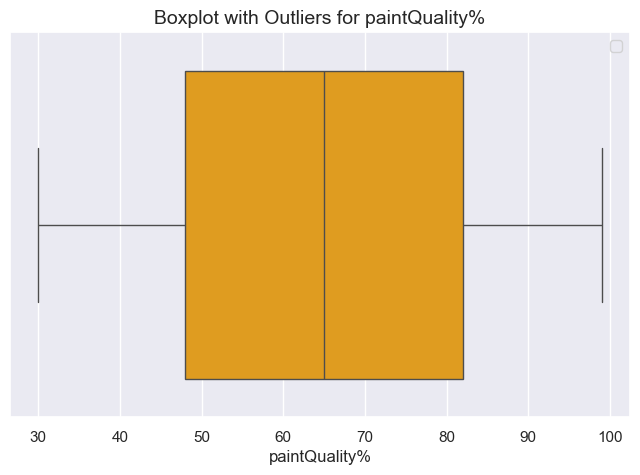

Column: previousOwners - Number of Outliers: 0
Column: previousOwners - % of Outliers: 0.00%



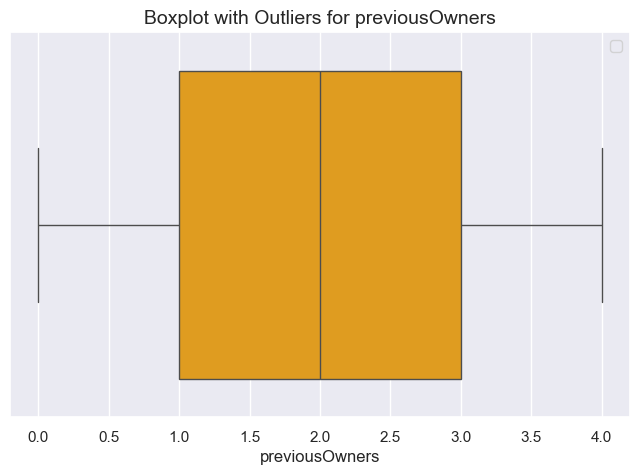

Column: carAge - Number of Outliers: 1438
Column: carAge - % of Outliers: 2.37%



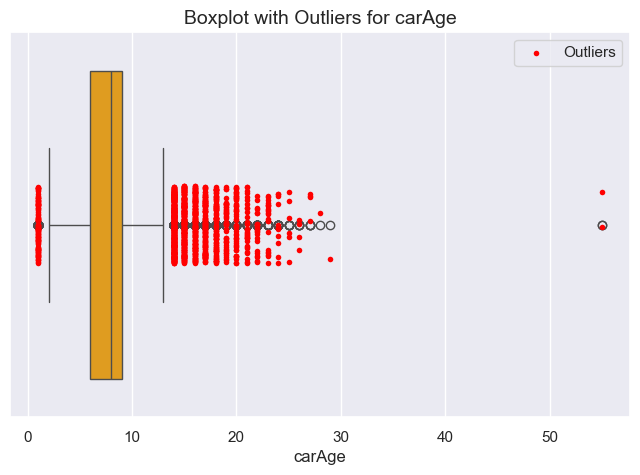

,Column,Num_Outliers,Pct_Outliers
0,mileage,2657,4.371648
1,tax,16024,26.364803
2,mpg,1367,2.249169
3,engineSize,496,0.816085
4,carAge,1438,2.365988


In [ ]:
#This helper prints potential outliers per numeric column; used for manual review we don't automatically remove them here.
detect_outliers_iqr(X_train[['mileage','tax','mpg','engineSize','paintQuality%','previousOwners','carAge']], threshold=0.001)

### 3.3.2 Dealing with outliers

Case-by-case review

***mileage*** — Since having more than 250000 miles in 15+ years is completely possible, we will not treat them as wrong values

In [35]:
X_train[X_train['mileage'] > 250000]

,Unnamed: 0,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,carAge,Brand_audi,Brand_bmw,...,Brand_volkswagen,transmission_automatic,transmission_manual,transmission_semi-auto,fuelType_diesel,fuelType_electric,fuelType_hybrid,fuelType_petrol,hasDamage,model_te
4840,4840,300000.0,125.0,57.6,1.9,79.0,2.0,15.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.650858
6658,6658,323000.0,200.0,44.1,2.0,74.0,1.0,17.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.236192


***tax*** - `tax==0` and `tax>500` both appear for plausible reasons (emissions bands, EVs, old/large engines). We **keep** them.

In [36]:
X_train[X_train['tax'] == 0]

,Unnamed: 0,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,carAge,Brand_audi,Brand_bmw,...,Brand_volkswagen,transmission_automatic,transmission_manual,transmission_semi-auto,fuelType_diesel,fuelType_electric,fuelType_hybrid,fuelType_petrol,hasDamage,model_te
72820,72820,41198.0,0.0,65.7,1.0,94.0,3.0,8.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.105911
66685,66685,35920.0,0.0,69.0,1.0,46.0,1.0,10.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.001852
14544,14544,15337.0,0.0,74.3,1.5,61.0,2.0,8.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.371651
6035,6035,41020.0,0.0,74.3,1.5,63.0,1.0,9.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.371651
33147,33147,48687.0,0.0,74.3,1.5,33.0,1.0,9.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.371651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15588,15588,30439.0,0.0,78.5,1.6,30.0,4.0,8.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.432462
13640,13640,50777.0,0.0,72.4,1.6,59.0,3.0,9.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.526890
6521,6521,20576.0,0.0,76.3,1.5,50.0,0.0,11.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.424675
8752,8752,55000.0,0.0,76.3,1.6,77.0,0.0,9.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.432462


In [37]:
X_train.loc[(X_train['tax'] == 0) & (X_train['fuelType_electric'] == 1)].shape[0]

4

In [38]:
X_train[X_train['tax'] > 500].sample(20)

,Unnamed: 0,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,carAge,Brand_audi,Brand_bmw,...,Brand_volkswagen,transmission_automatic,transmission_manual,transmission_semi-auto,fuelType_diesel,fuelType_electric,fuelType_hybrid,fuelType_petrol,hasDamage,model_te
34690,34690,3000.0,570.0,21.4,6.200000,78.0,4.0,14.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.680054
45190,45190,42422.0,555.0,28.8,5.500000,43.0,3.0,10.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.271494
51353,51353,8470.0,570.0,23.5,5.000000,56.0,1.0,8.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.493750
53066,53066,39000.0,570.0,23.5,6.200000,36.0,1.0,12.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.028573
9621,9621,113000.0,555.0,31.4,3.000000,91.0,0.0,19.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.962069
25488,25488,43000.0,570.0,25.2,3.000000,74.0,0.0,13.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.812500
16458,16458,22579.0,555.0,28.2,4.000000,46.0,2.0,8.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.000000
35148,35148,19953.0,555.0,28.0,5.500000,77.0,2.0,9.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.143750
68730,68730,26000.0,565.0,28.5,4.400000,34.0,2.0,9.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.400000
28933,28933,35000.0,570.0,21.9,5.200000,48.0,2.0,11.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.066667


***mpg*** - Since every car with > 400 mpg have the same brand and model, we do not consider those values as wrong values

In [39]:
X_train[X_train['mpg']>400]

,Unnamed: 0,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,carAge,Brand_audi,Brand_bmw,...,Brand_volkswagen,transmission_automatic,transmission_manual,transmission_semi-auto,fuelType_diesel,fuelType_electric,fuelType_hybrid,fuelType_petrol,hasDamage,model_te
54333,54333,22214.0,0.0,470.8,0.600000,95.0,4.0,8.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.674253
70578,70578,19995.0,0.0,470.8,0.600000,79.0,3.0,9.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.674253
4101,4101,33931.0,0.0,470.8,0.600000,31.0,4.0,10.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.674253
46823,46823,43695.0,0.0,470.8,0.600000,81.0,1.0,9.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.674253
48149,48149,36429.0,0.0,470.8,0.600000,30.0,2.0,8.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.674253
50071,50071,65800.0,0.0,470.8,0.600000,50.0,3.0,10.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.674253
63762,63762,20929.0,135.0,470.8,0.600000,71.0,2.0,8.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.674253
5278,5278,23956.0,135.0,470.8,0.600000,53.0,1.0,8.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.674253
29581,29581,26965.0,140.0,470.8,0.600000,81.0,3.0,8.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.674253
24975,24975,9886.0,0.0,470.8,0.600000,44.0,0.0,10.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.674253


***engineSize*** - Since all the cars with engineSize > 6 are all from the same brand (almost all from the same model) we will not considerer those values as wrong values

In [40]:
X_train[X_train['engineSize']>6]

,Unnamed: 0,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,carAge,Brand_audi,Brand_bmw,...,Brand_volkswagen,transmission_automatic,transmission_manual,transmission_semi-auto,fuelType_diesel,fuelType_electric,fuelType_hybrid,fuelType_petrol,hasDamage,model_te
20432,20432,49964.0,326.0,57.7,6.2,58.0,3.0,7.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.028573
59468,59468,56444.0,580.0,23.5,6.2,65.0,0.0,11.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.028573
70337,70337,56444.0,145.0,57.7,6.2,52.0,3.0,11.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.028573
53066,53066,39000.0,570.0,23.5,6.2,36.0,1.0,12.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.028573
20916,20916,41866.0,570.0,23.5,6.2,80.0,0.0,12.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.028573
6030,6030,24175.0,145.0,57.7,6.2,93.0,2.0,11.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.028573
4049,4049,43442.0,145.0,57.7,6.2,76.0,0.0,12.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.028573
34252,34252,37000.0,570.0,23.5,6.2,92.0,2.0,11.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.028573
24327,24327,44000.0,145.0,57.7,6.2,88.0,2.0,12.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.028573
34690,34690,3000.0,570.0,21.4,6.2,78.0,4.0,14.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.680054


***carAge*** - Values >50 treated as outliers; we replace with **median by model_te** (rounded) to avoid unrealistic antiques dominating.

In [41]:
X_train[X_train['carAge']>50]

,Unnamed: 0,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,carAge,Brand_audi,Brand_bmw,...,Brand_volkswagen,transmission_automatic,transmission_manual,transmission_semi-auto,fuelType_diesel,fuelType_electric,fuelType_hybrid,fuelType_petrol,hasDamage,model_te
11425,11425,37357.0,200.0,42.2,1.4,60.0,2.0,55.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.508571
34917,34917,14000.0,305.0,39.2,2.1,44.0,3.0,55.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.608093


In [ ]:
# Learn replacement medians on TRAIN only
carAge_median_by_model = X_train.groupby('model_te')['carAge'].median()
global_median_carAge   = float(X_train['carAge'].median())  # fallback

def replace_carAge_outliers(df, per_model_median, thr=50, global_med=None, to_int=True):
    """Replace carAge values above `thr` by the model-level median (or global fallback)."""
    out = df.copy()
    s = pd.to_numeric(out['carAge'], errors='coerce').astype('Float64')
    mask = s > thr

    # replace median by model
    repl = out.loc[mask, 'model_te'].map(per_model_median)
    if global_med is not None:
        repl = repl.fillna(global_med)

    s.loc[mask] = repl
    if to_int:
        s = s.round().astype('Int64') 
    out['carAge'] = s
    return out



In [43]:
X_train = replace_carAge_outliers(X_train, carAge_median_by_model, thr=50, global_med=global_median_carAge)
X_val = replace_carAge_outliers(X_val, carAge_median_by_model, thr=50, global_med=global_median_carAge)
test_encoded = replace_carAge_outliers(test_encoded, carAge_median_by_model, thr=50, global_med=global_median_carAge)

## 3.4 Scaling

We apply **RobustScaler**, which uses medians/IQRs and is **resistant to outliers & skew** (fits well with used-car data).

In [44]:
# Initialize the scaler
scaler = RobustScaler()

In [ ]:
# Numeric columns to scale (including our encoded `model_te`)
num = ['mileage', 'engineSize', 'tax', 'mpg', 'carAge', 'paintQuality%','previousOwners','model_te']

In [ ]:
# Fit the scaler only on TRAIN data
scaler.fit(X_train[num])

# Transform both TRAIN and VALIDATION sets
X_train[num] = scaler.transform(X_train[num])
X_val[num] = scaler.transform(X_val[num])
# And TEST
test_encoded[num] = scaler.transform(test_encoded[num])

In [47]:
print(X_train[num].describe())

            mileage    engineSize           tax           mpg        carAge  \
count  60778.000000  60778.000000  60778.000000  60778.000000  60778.000000   
mean       0.235737      0.081022     -1.063671     -0.069306     -0.032457   
std        0.865328      0.701402      3.064986      1.093091      0.725938   
min       -0.702178     -1.806838     -7.250000     -3.874126     -2.333333   
25%       -0.399703     -0.500000     -1.000000     -0.657343     -0.666667   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.600297      0.500000      0.000000      0.342657      0.333333   
max       12.282837      6.250000     21.750000     28.972028      7.000000   

       paintQuality%  previousOwners      model_te  
count   60778.000000    60778.000000  60778.000000  
mean       -0.013792       -0.031780      0.023915  
std         0.586602        0.718543      0.744031  
min        -1.029412       -1.000000     -1.098755  
25%        -0.500000   

# 4.Feature Selection

We compare **filter** (Spearman, Chi²), **wrapper** (RFE/forward with RF), and **embedded** (Lasso) strategies to have a stable subset.

In [48]:
X_train.columns

Index(['Unnamed: 0', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'previousOwners', 'carAge', 'Brand_audi', 'Brand_bmw', 'Brand_ford',
       'Brand_hyundai', 'Brand_mercedes-benz', 'Brand_opel', 'Brand_skoda',
       'Brand_toyota', 'Brand_unknown', 'Brand_volkswagen',
       'transmission_automatic', 'transmission_manual',
       'transmission_semi-auto', 'fuelType_diesel', 'fuelType_electric',
       'fuelType_hybrid', 'fuelType_petrol', 'hasDamage', 'model_te'],
      dtype='object')

In [ ]:
# Numeric set (post-scaling) used in rank correlations
numeric = [
    'mileage',
    'tax',
    'mpg',
    'engineSize',
    'paintQuality%',
    'previousOwners',
    'carAge',
    'model_te'
]


In [ ]:
# One-hot encoded categorical features
encoded_features = [
    'Brand_audi',
    'Brand_bmw',
    'Brand_ford',
    'Brand_hyundai',
    'Brand_mercedes-benz',
    'Brand_opel',
    'Brand_skoda',
    'Brand_toyota',
    'Brand_volkswagen',
    'transmission_automatic',
    'transmission_manual',
    'transmission_semi-auto',
    'fuelType_diesel',
    'fuelType_electric',
    'fuelType_hybrid',
    'fuelType_petrol'
]


In [ ]:
# Binary flags
binary_features = ['hasDamage']

In [ ]:
# Union of all predictors considered
categ_features = encoded_features + binary_features 

all_features = numeric + categ_features

### 4.1 Filter-Based Methods

**Variance check**. Very low variance can harm linear models but is OK for trees; we keep for now.

In [53]:
X_train[numeric].var()

mileage           0.748793
tax               9.394142
mpg               1.194848
engineSize        0.491964
paintQuality%     0.344102
previousOwners    0.516303
carAge            0.526986
model_te          0.553583
dtype: float64

**Spearman Correlation Matrix (rank-based)** — we use **Spearman** because most numeric variables are **skewed** with **outliers**.

In [54]:
cor_spearman = X_train[numeric].corr(method ='spearman')
cor_spearman

,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,carAge,model_te
mileage,1.000000,-0.244863,0.305259,0.097467,-0.001430,0.005869,0.785212,0.032398
tax,-0.244863,1.000000,-0.526084,0.150768,-0.001155,0.002987,-0.300233,0.161945
mpg,0.305259,-0.526084,1.000000,-0.194498,0.002801,0.000537,0.289164,-0.242745
engineSize,0.097467,0.150768,-0.194498,1.000000,0.003459,0.005404,0.032466,0.808890
paintQuality%,-0.001430,-0.001155,0.002801,0.003459,1.000000,-0.005854,-0.004928,0.002013
previousOwners,0.005869,0.002987,0.000537,0.005404,-0.005854,1.000000,-0.001472,0.000978
carAge,0.785212,-0.300233,0.289164,0.032466,-0.004928,-0.001472,1.000000,-0.051080
model_te,0.032398,0.161945,-0.242745,0.808890,0.002013,0.000978,-0.051080,1.000000


In [55]:
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = 'PiYG', fmt='.1')
    plt.show()

**Chi-Square Test** — assesses association between **categorical predictors** (one-hots) and a **discretized** target.

Here we crosstab one-hots vs. `y_train` directly as counts to flag informative categories.

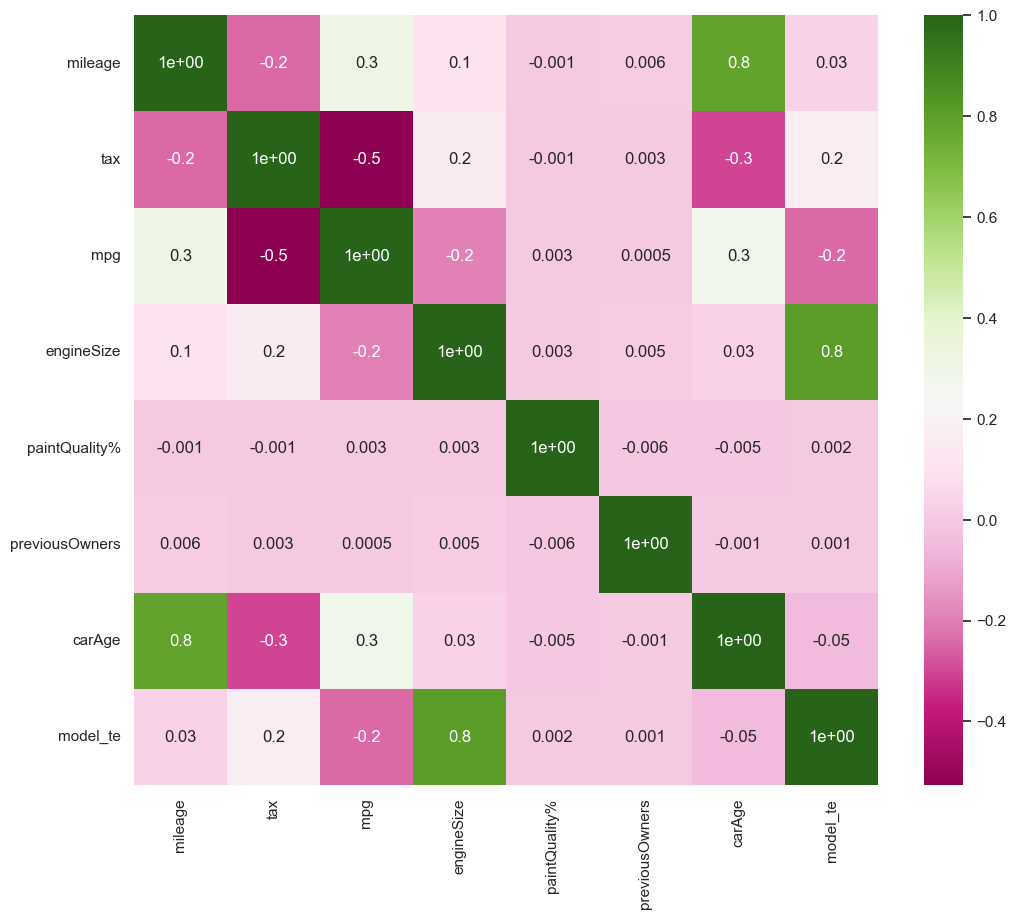

In [56]:
cor_heatmap(cor_spearman)

**Chi Squared Test**

In [57]:
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [58]:
for var in encoded_features:
    TestIndependence(X_train[var], y_train, var)

Brand_audi is IMPORTANT for Prediction
Brand_bmw is IMPORTANT for Prediction
Brand_ford is IMPORTANT for Prediction
Brand_hyundai is NOT an important predictor. (Discard Brand_hyundai from model)
Brand_mercedes-benz is IMPORTANT for Prediction
Brand_opel is IMPORTANT for Prediction
Brand_skoda is NOT an important predictor. (Discard Brand_skoda from model)
Brand_toyota is IMPORTANT for Prediction
Brand_volkswagen is IMPORTANT for Prediction
transmission_automatic is IMPORTANT for Prediction
transmission_manual is IMPORTANT for Prediction
transmission_semi-auto is IMPORTANT for Prediction
fuelType_diesel is IMPORTANT for Prediction
fuelType_electric is NOT an important predictor. (Discard fuelType_electric from model)
fuelType_hybrid is IMPORTANT for Prediction
fuelType_petrol is IMPORTANT for Prediction


**Inspect some slices if needed**

In [59]:
X_train[X_train['Brand_hyundai'] == 1]

,Unnamed: 0,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,carAge,Brand_audi,Brand_bmw,...,Brand_volkswagen,transmission_automatic,transmission_manual,transmission_semi-auto,fuelType_diesel,fuelType_electric,fuelType_hybrid,fuelType_petrol,hasDamage,model_te
42020,42020,0.896954,-5.75,0.643357,0.125,1.000000,-1.0,0.666667,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.012692
16467,16467,-0.532488,0.00,-0.713287,-0.500,0.000000,1.0,-0.333333,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.762259
7618,7618,0.307762,0.00,-0.153846,0.500,-0.764706,0.5,0.000000,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.056366
57014,57014,0.535262,-6.25,1.111888,0.000,-0.382353,1.0,0.666667,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.287886
59090,59090,0.234274,2.75,-0.601399,0.500,-0.852941,-1.0,0.000000,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.056366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11605,11605,0.609835,0.00,0.251748,-0.750,-0.823529,-1.0,0.000000,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.954802
32904,32904,1.036131,-5.75,-0.076923,-0.500,-0.764706,1.0,0.333333,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.762259
46774,46774,0.669575,-1.00,-0.426573,-0.250,0.176471,0.0,0.666667,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.293240
33930,33930,-0.617795,0.00,-1.419580,0.000,-0.147059,0.0,-0.666667,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.056366


In [60]:
X_train[X_train['Brand_skoda'] == 1]

,Unnamed: 0,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,carAge,Brand_audi,Brand_bmw,...,Brand_volkswagen,transmission_automatic,transmission_manual,transmission_semi-auto,fuelType_diesel,fuelType_electric,fuelType_hybrid,fuelType_petrol,hasDamage,model_te
7944,7944,1.795897,0.00,0.538462,0.50,-0.735294,0.5,0.000000,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.303565
14235,14235,0.087619,0.25,0.083916,-0.25,0.794118,-1.0,0.000000,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.000329
11087,11087,0.483723,-6.25,0.251748,-0.50,0.294118,0.0,0.000000,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.935511
17429,17429,0.232545,0.00,-0.293706,0.50,0.000000,1.0,-0.666667,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.249216
53343,53343,-0.569553,0.25,-1.090909,0.50,-0.735294,-1.0,-0.666667,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.249216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66509,66509,0.738198,0.25,-1.090909,-0.25,0.911765,-1.0,0.000000,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.249216
37237,37237,-0.299641,-6.25,0.440559,-0.75,0.823529,1.0,0.333333,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.098755
11723,11723,-0.174977,0.00,0.867133,0.00,0.588235,0.0,-0.666667,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.000329
47954,47954,0.797134,-5.75,0.083916,-0.25,-0.588235,0.5,0.333333,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.000329


In [61]:
X_train[X_train['fuelType_electric'] == 1]

,Unnamed: 0,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,carAge,Brand_audi,Brand_bmw,...,Brand_volkswagen,transmission_automatic,transmission_manual,transmission_semi-auto,fuelType_diesel,fuelType_electric,fuelType_hybrid,fuelType_petrol,hasDamage,model_te
52274,52274,0.283963,-7.25,0.755245,0.500000,0.500000,1.0,0.333333,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.417512
6978,6978,0.482316,-7.25,28.972028,2.778447,0.058824,0.0,0.666667,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.038774
37023,37023,0.683163,-7.25,12.510490,-0.250000,0.529412,-0.5,0.666667,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.419622
52579,52579,-0.324486,-7.25,0.755245,0.500000,-0.176471,0.5,0.333333,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.417512


### 4.2 Wrapper Methods

We use **RandomForest + RFE** and a **top-k sweep** to see how many features we actually need.

**RFE**

In [62]:
estimator = RandomForestRegressor(n_estimators=200, random_state=0, n_jobs=-1)

selector = RFE(
    estimator=estimator,
    n_features_to_select=12,   
    step=1,
    verbose=1
)

selector.fit(X_train, y_train)

selected_features = X_train.columns[selector.support_]
print("Selected features:", selected_features)

y_pred = estimator.fit(X_train[selected_features], y_train).predict(X_val[selected_features])
print("Validation MAE:", mean_absolute_error(y_val, y_pred))

Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Selected features: Index(['Unnamed: 0', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'carAge', 'Brand_audi', 'Brand_bmw', 'Brand_ford',
       'transmission_manual', 'model_te'],
      dtype='object')
Validation MAE: 1393.2912576505428


Best k = 24 with Validation MAE = 1360.123
Selected features: ['transmission_manual', 'carAge', 'engineSize', 'model_te', 'mileage', 'mpg', 'tax', 'Unnamed: 0', 'paintQuality%', 'Brand_audi', 'Brand_ford', 'previousOwners', 'Brand_bmw', 'Brand_mercedes-benz', 'fuelType_petrol', 'fuelType_diesel', 'Brand_volkswagen', 'Brand_opel', 'Brand_skoda', 'transmission_semi-auto', 'transmission_automatic', 'Brand_toyota', 'fuelType_hybrid', 'Brand_hyundai']


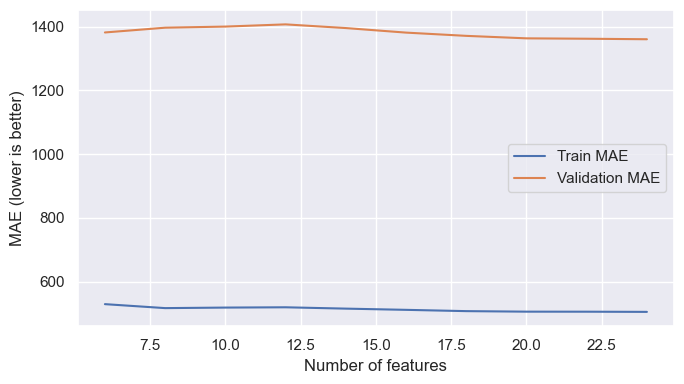

In [ ]:
# Base model (smaller n_estimators during selection to be fast)
ranker = RandomForestRegressor(
    n_estimators=150,      # smaller for speed; increase later for final model
    random_state=42,
    n_jobs=-1
)
ranker.fit(X_train, y_train)

# Feature ranking by impurity-based importance (fast)
importances = ranker.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
sorted_feats = X_train.columns[sorted_idx]

# 2) Sweep top-k subsets (10–15 fits only)
k_grid = list(range(6, min(26, X_train.shape[1] + 1), 2))
train_mae, val_mae = [], []
best_k, best_mae, best_feats = None, np.inf, None

for k in k_grid:
    feats_k = list(sorted_feats[:k])
    model_k = RandomForestRegressor(
           # keep it light for the sweep
        n_estimators=150,
        random_state=42,
        n_jobs=-1
    )
    model_k.fit(X_train[feats_k], y_train)
    y_tr = model_k.predict(X_train[feats_k])
    y_va = model_k.predict(X_val[feats_k])

    tr_mae = mean_absolute_error(y_train, y_tr)
    va_mae = mean_absolute_error(y_val, y_va)
    train_mae.append(tr_mae)
    val_mae.append(va_mae)

    if va_mae < best_mae:
        best_mae = va_mae
        best_k = k
        best_feats = feats_k

print(f"Best k = {best_k} with Validation MAE = {best_mae:.3f}")
print("Selected features:", best_feats)

# 3) Retrain a stronger final model on the chosen features
final_model = RandomForestRegressor(
    # now you can increase for accuracy
    n_estimators=400, 
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_train[best_feats], y_train)



plt.figure(figsize=(7,4))
plt.plot(k_grid, train_mae, label="Train MAE")
plt.plot(k_grid, val_mae, label="Validation MAE")
plt.xlabel("Number of features")
plt.ylabel("MAE (lower is better)")
plt.legend()
plt.tight_layout()
plt.show()

### 4.3 Embedded Methods

**LassoCV** (L1-regularized linear model) performs **embedded selection** by shrinking some coefficients to **zero**.

Works well after scaling; still robust to multicollinearity.

In [64]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [65]:
reg = LassoCV()

In [66]:
reg.fit(X_train[all_features], y_train)

LassoCV()

In [67]:
coef = pd.Series(reg.coef_, index = X_train[all_features].columns)
coef

mileage                  -2786.009371
tax                        -66.651913
mpg                       -570.928026
engineSize                4484.124915
paintQuality%              -39.383924
previousOwners               0.000000
carAge                   -3668.286906
model_te                  4310.441376
Brand_audi                2635.396399
Brand_bmw                   -0.000000
Brand_ford                 757.677357
Brand_hyundai            -1115.843386
Brand_mercedes-benz       2050.859034
Brand_opel               -2443.065301
Brand_skoda                 -0.000000
Brand_toyota             -1731.186124
Brand_volkswagen           829.192093
transmission_automatic      -0.000000
transmission_manual      -1673.255552
transmission_semi-auto     591.911355
fuelType_diesel          -1598.917257
fuelType_electric            0.000000
fuelType_hybrid           1949.483870
fuelType_petrol             -0.000000
hasDamage                    0.000000
dtype: float64

In [68]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 18 variables and eliminated the other 7 variables


In [69]:
coef.sort_values()

carAge                   -3668.286906
mileage                  -2786.009371
Brand_opel               -2443.065301
Brand_toyota             -1731.186124
transmission_manual      -1673.255552
fuelType_diesel          -1598.917257
Brand_hyundai            -1115.843386
mpg                       -570.928026
tax                        -66.651913
paintQuality%              -39.383924
fuelType_electric            0.000000
transmission_automatic      -0.000000
Brand_skoda                 -0.000000
hasDamage                    0.000000
Brand_bmw                   -0.000000
previousOwners               0.000000
fuelType_petrol             -0.000000
transmission_semi-auto     591.911355
Brand_ford                 757.677357
Brand_volkswagen           829.192093
fuelType_hybrid           1949.483870
Brand_mercedes-benz       2050.859034
Brand_audi                2635.396399
model_te                  4310.441376
engineSize                4484.124915
dtype: float64

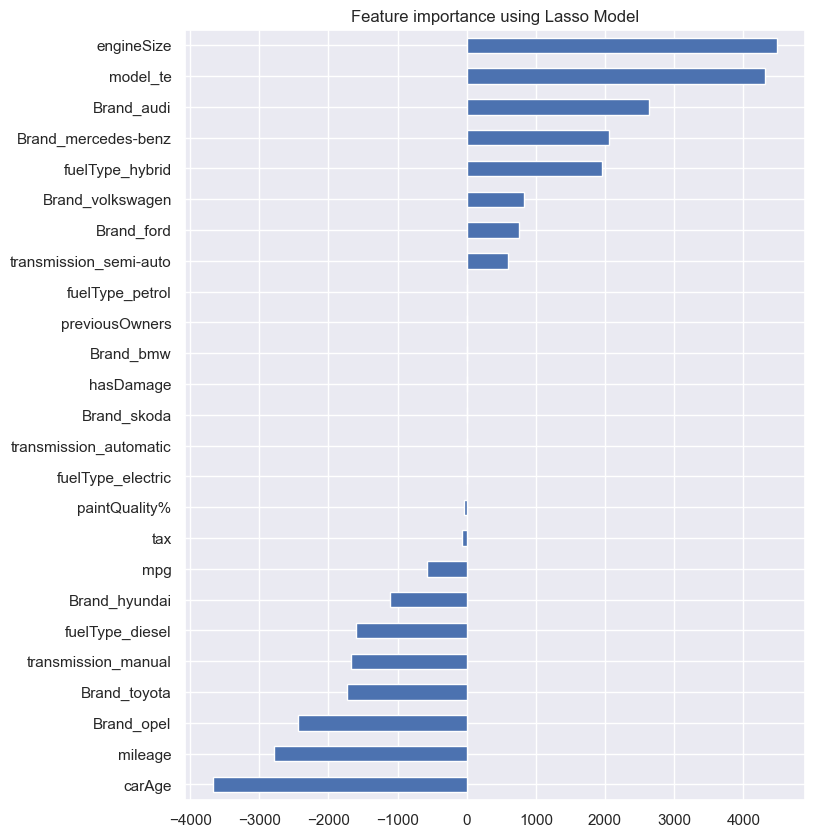

In [70]:
plot_importance(coef,'Lasso')

In [71]:
print(numeric, categ_features)

['mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'carAge', 'model_te'] ['Brand_audi', 'Brand_bmw', 'Brand_ford', 'Brand_hyundai', 'Brand_mercedes-benz', 'Brand_opel', 'Brand_skoda', 'Brand_toyota', 'Brand_volkswagen', 'transmission_automatic', 'transmission_manual', 'transmission_semi-auto', 'fuelType_diesel', 'fuelType_electric', 'fuelType_hybrid', 'fuelType_petrol', 'hasDamage']


### 4.4 Final Features

Consolidation table below summarizes **signals across methods** and a pragmatic decision (keep / drop / try both).


| Predictor              | Spearman  | RFE RF | Lasso | Chi-Square | What to do? (One possible way to "solve") |
|-------------------------|-----------------|---------|-------|-------------|--------------------------------------------|
| model_te               | Keep      | Keep    | Keep  | -           | Keep|
| engineSize             | Choose between 'model_te' and 'engineSize'       | Keep    | Keep  | -    | Try with and without                                      |
| Brand_ford             | -      | Keep      | Keep     | Keep           | Keep                                          |
| fuelType_hybrid        | -      | Keep    | Keep  | Keep          | Keep                      |
| Brand_audi             | -          | Keep       | Keep    | Keep           | Keep                                          |
| transmission_semi-auto | -        | Keep    | Keep  | Keep          | Keep                    |
| Brand_volkswagen       | -      | Keep    | Keep  | Keep           | Keep                      |
| Brand_mercedes-benz    | -          | Keep       | Keep     | Keep           | Keep                                          |
| previousOwners         | Discard     | Keep | Discard | -        | Discard                      |
| paintQuality%          | Discard     | Keep   | Discard     | -        | Discard                      |
| hasDamage              | -      | Discard    | Discard     | -        | Discard                      |
| fuelType_electric      | -      | Keep    | Discard     | Discard        | Discard                      |
| transmission_automatic | -      | Keep    | Discard     | Keep        | Try with and without                      |
| fuelType_petrol        | -      | Keep    | Discard     | Keep        | Try with and without                      |
| Brand_hyundai          | -     | Keep       | Keep     | Keep           | Keep                                         |
| Brand_bmw              | -       | Keep       | Discard     | Keep           | Try with and without                                          |
| Brand_skoda            | -       | Keep       | Discard   | Discard           | Discard                                          |
| tax                    | Keep        | Keep    | Keep  | -     | Keep                                      |
| Brand_opel             | -    | Keep       | Keep  | Keep           | Keep                                          |
| Brand_toyota           | -    | Keep       | Keep  | Keep           | Keep                                          |
| mpg                    | Keep     | Keep | Keep  | -       | Keep                      |
| transmission_manual    | -      | Keep    | Keep | Keep        | Keep                      |
| fuelType_diesel        | -     | Keep    | Keep | Keep        | Keep                      |
| mileage                | Keep       | Keep    | Keep | -     | Keep               |
| carAge                 | Choose between 'carAge' and 'mileage'      | Keep    | Keep | -       | Try with and without                      |


Let's create a new list with the selected features

In [72]:
cols_selected = ['mileage', 'tax', 'mpg', 'engineSize' , 'carAge', 'model_te','Brand_audi', 'Brand_bmw', 'Brand_ford', 'Brand_hyundai', 'Brand_mercedes-benz', 'Brand_opel',  'Brand_toyota', 'Brand_volkswagen', 'transmission_automatic', 'transmission_manual', 'transmission_semi-auto', 'fuelType_diesel',  'fuelType_hybrid', 'fuelType_petrol']

In [73]:
X_train_filtered = X_train[cols_selected]
X_val_filtered = X_val[cols_selected]
test_filtered = test_encoded[['carID'] + cols_selected]

# 5. Export

In [74]:
X_train_filtered.to_csv('./X_train_filtered_data.csv')
y_train.to_csv('./y_train_data.csv')

X_val_filtered.to_csv('./X_val_filtered_data.csv')
y_val.to_csv('./y_val_data.csv')

test_filtered.to_csv('./test_filtered_data.csv')